# Analise descritiva dos dados

# Imports

In [109]:
import pandas as pd
import inflection
import math
import seaborn as sns
import datetime as dt
import numpy as np
import xgboost as xgb

from matplotlib import gridspec
from matplotlib import pyplot as plt
from IPython.display import Image  
from tabulate import tabulate
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder 
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.multioutput import MultiOutputRegressor

### Helper Function

In [2]:
def cramer_v(x,y):
    #confusion map, contagem de numeros de linhas para cada valor categorico selecionado. 
    cm = pd.crosstab(x,y).values

    chi2 = stats.chi2_contingency(cm)[0]
    
    n = cm.sum()
    
    r, k = df_4.shape

    phi_corr = max(0, (chi2/n)-((k-1)*(r-1)/n-1))

    k_corr = k - ((k-1)**2)/(n-1)

    r_corr = k_corr = r - ((r-1)**2)/(n-1)

    if min(k_corr-1,r_corr-1) != 0:
        return np.sqrt(phi_corr/(min(k_corr-1,r_corr-1)))
    else: return 0.0

In [105]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    m_result_df = pd.DataFrame(columns=['Model Name','MAE','MAPE','RMSE'])

    for k in reversed(range(kfold +1)):
        if verbose:
            print('kFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - dt.timedelta(days=k*7*6)
        validation_end_date = x_training['date'].max() - dt.timedelta(days=(k-1)*7*6)

        # filtering dataset 
        training = x_training[x_training['date']<validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date)&(x_training['date'] <= validation_end_date)]

        # training 
        x__training = training.drop(['date','sales'], axis=1)
        y__training = training['sales']

        # validation 
        x__validation = validation.drop(['date','sales'], axis=1)
        y__validation = validation['sales']

        #prediction
        m = model.fit(x__training,y__training.values)
        yhat_lr = m.predict(x__validation)

        #perfomance
        m_result = ml_error('Linear Regression',y=np.expm1(y__validation), yhat=np.expm1(yhat_lr))

        m_result_df = pd.concat([m_result_df, m_result], axis=0, ignore_index=True)

    error_dict = {
    'Model Name':model_name,
    'MAE CV': str(np.round(m_result_df['MAE'].mean(),decimals=2)) + ' +/- ' + str(np.round(m_result_df['MAE'].std(),decimals=2)),  
    'MAPE CV':str(np.round(m_result_df['MAPE'].mean(),decimals=2)) + ' +/- ' + str(np.round(m_result_df['MAPE'].std(),decimals=2)),  
    'RMSE CV':str(np.round(m_result_df['RMSE'].mean(),decimals=2)) + ' +/- ' + str(np.round(m_result_df['RMSE'].std(),decimals=2))
    }

    return pd.DataFrame(data=error_dict,index=[0])

# Loading Data

In [4]:
# Loading train.csv
df_sales = pd.read_csv('/home/data_science/repos/DataScience_Em_Producao/datasets/rossmann-store-sales/train.csv', low_memory=False)
# Loading store.csv
df_store = pd.read_csv('/home/data_science/repos/DataScience_Em_Producao/datasets/rossmann-store-sales/store.csv', low_memory=False)

# merge 
df_raw = pd.merge(right=df_store,left=df_sales,how='left',on='Store')


In [5]:
df_sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
df_raw[df_raw['Store']==1]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1115,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2230,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3345,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4460,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011635,1,6,2013-01-05,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1012750,1,5,2013-01-04,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1013865,1,4,2013-01-03,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1014980,1,3,2013-01-02,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


#  Rename Columns 

In [7]:
columns = df_raw.columns.to_list()

snake_case = lambda x: inflection.underscore(x)
columns = list(map(snake_case,columns))

df_raw.columns = columns

# Descricao dos Dados

In [8]:
df_1 = df_raw.copy()

## --> Data Dimension

In [9]:
print('Number of raw: {}'.format(df_1.shape[0]))
print('Number of columns: {}'.format(df_1.shape[1]))

Number of raw: 1017209
Number of columns: 18


## --> Data Types

In [10]:
df_1['date'] = pd.to_datetime(df_1['date'])
df_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## --> Check NA

In [11]:
df_1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [12]:
# Porcentage (%)
df_1.isna().sum() / df_1.shape[0]

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

## --> Replacing missing data

In [13]:
df_1['competition_distance'].max()

75860.0

In [14]:
#competition_distance
df_1['competition_distance'] = df_1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)         

#competition_open_since_month
df_1['competition_open_since_month'] = df_1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

#competition_open_since_year  
df_1['competition_open_since_year'] = df_1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

#promo2_since_week
df_1['promo2_since_week'] = df_1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1) 
            
#promo2_since_year
df_1['promo2_since_year'] = df_1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1) 

#promo_interval
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}

df_1['promo_interval'].fillna(0,inplace=True)

df_1['month_map'] = df_1['date'].dt.month.map(month_map)

df_1['is_promo'] = df_1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## --> Change Dtypes

In [15]:
df_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
#float64 to int64
df_1['competition_open_since_month'] = df_1['competition_open_since_month'].astype(int)
df_1['competition_open_since_year'] = df_1['competition_open_since_year'].astype(int)

df_1['promo2_since_week'] = df_1['promo2_since_week'].astype(int)
df_1['promo2_since_year'] = df_1['promo2_since_year'].astype(int)

## --> Descriptive Statical

In [17]:
num_attributes = df_1.select_dtypes(include=['int64','float64'])
cat_attributes = df_1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

In [18]:
# NUMERICAL ATTRIBUTES

# Central Tendency - mean, median
t1 = pd.DataFrame(num_attributes.mean()).T
t2 = pd.DataFrame(num_attributes.median()).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.std()).T 
d2 = pd.DataFrame(num_attributes.min()).T 
d3 = pd.DataFrame(num_attributes.max()).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

ml = pd.concat([d2,d3,d4,t1,t2,d1,d5,d6]).T.reset_index()
ml.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']


In [19]:

ml

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908651,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997391,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.926175,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411734,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485759,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.652996,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311087,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515593,-7.235657,124.071304


In [20]:
# CATEGORICAL ATTRIBUTES

cat_attributes.apply(lambda x: x.unique().shape[0])



state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

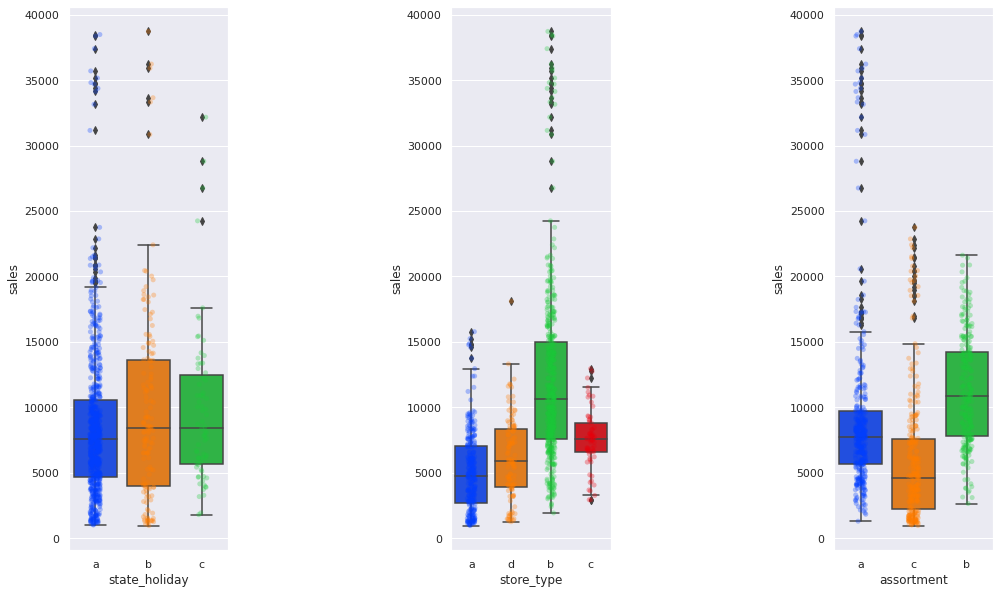

In [21]:
aux_1 = df_1[(df_1['state_holiday'] != '0') & (df_1['sales'] > 0)]

sns.set_theme(style="darkgrid", palette="bright")
plt.figure(figsize=(20,10))

plt.subplot(1,6,1)
sns.boxplot(x='state_holiday', y='sales', data=aux_1, palette='bright')
sns.stripplot(x='state_holiday', y='sales', data=aux_1, alpha=0.3) 

plt.subplot(1,6,3)
sns.boxplot(x='store_type', y='sales', data=aux_1, palette='bright') 
sns.stripplot(x='store_type', y='sales', data=aux_1, alpha=0.3) 

plt.subplot(1,6,5)
sns.boxplot(x='assortment', y='sales', data=aux_1, palette='bright') 
sns.stripplot(x='assortment', y='sales', data=aux_1, alpha=0.3) 

# Feature Engineering

## --> Mind Map das Hipoteses

In [22]:
df_2 = df_1.copy()

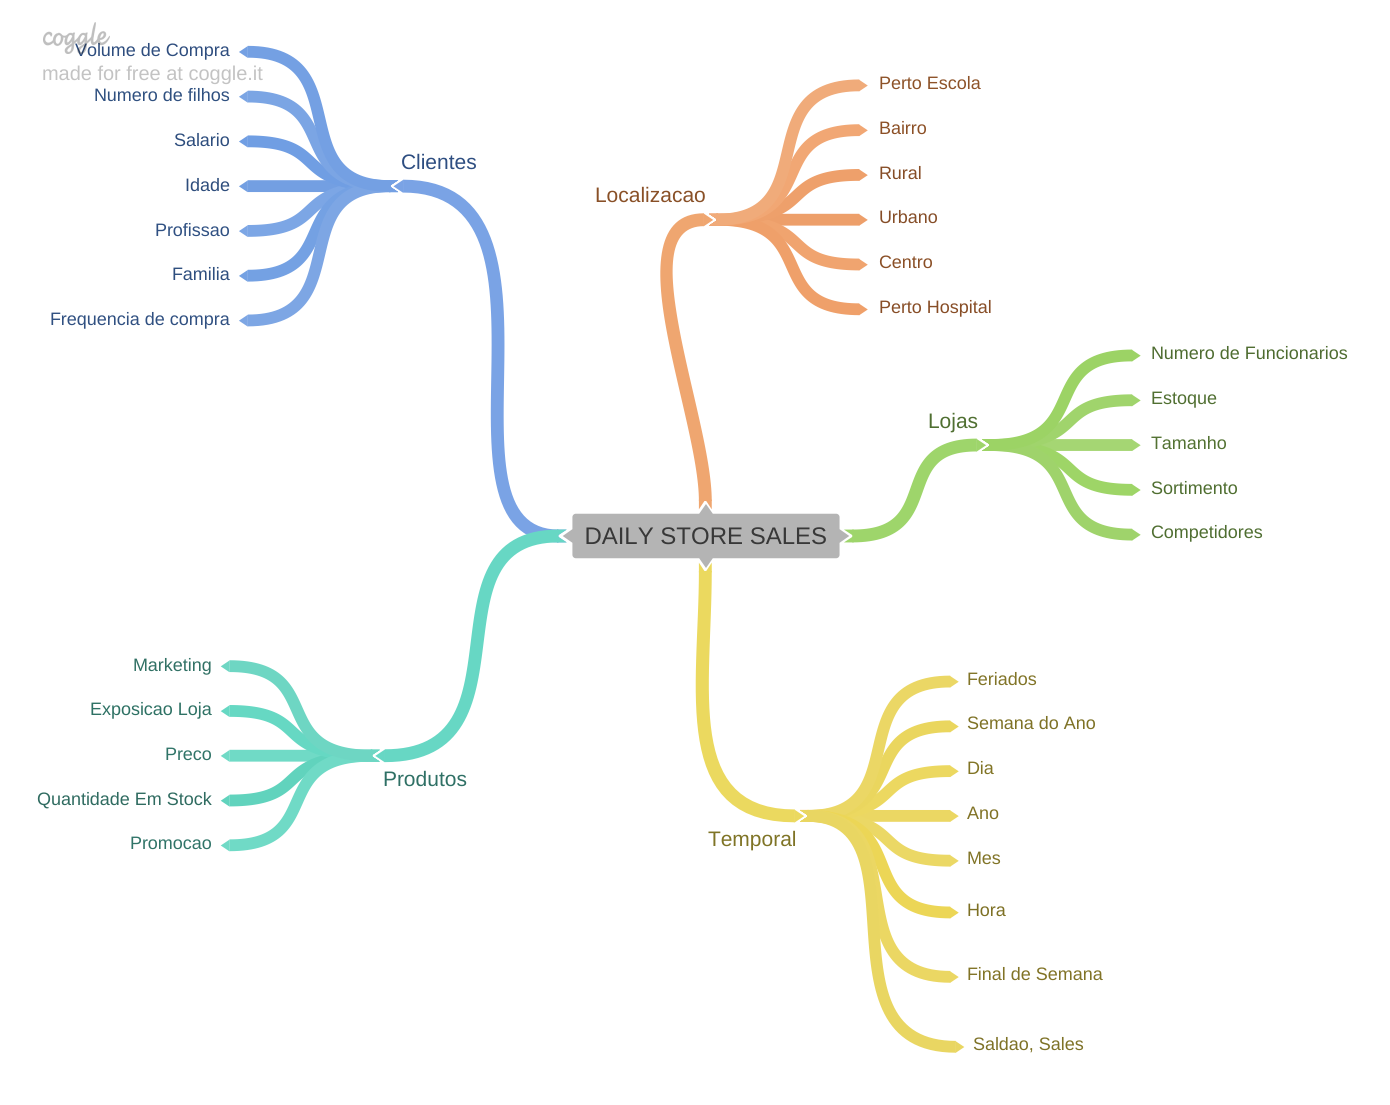

In [23]:
Image('/home/data_science/repos/DataScience_Em_Producao/img/mind_map-hypoteses.png')

## --> Criação de Hipóteses

### --> Hipóteses Loja

1. Lojas com número maior de funcionarios deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vander mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimento deveriam vender mais. 
5. Lojas com competidores mais próximos deveriam vender mais.
6. Lojas com competidores à mais tempo deveriam vender mais. 

### --> Hipóteses Produto

1. Lojas que investem mais em marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
4. Lojas com promoções mais agressivas (desconto maiores), deveriam vender mais.
5. Lojas com promoções ativas por mais tempo deveriam vender mais.
6. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consectivas deveriam vender mais.

### --> Hipóteses Tempo

1. Lojas que tem mais feriados deveriam vender mais.
2. Lojas que abrem nos primeiros 6 meses deveriam vender mais.
3. Lojas que abrem nos finais de semana deveriam vender mais.
4. Lojas deveriam vender mais depois do dia 10 de cada mes.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### --> Lista de prioridade das Hipóteses

1. Lojas com maior sortimento deveriam vender mais. 
2. Lojas com competidores mais próximos deveriam vender mais.
3. Lojas com competidores à mais tempo deveriam vender mais.  

4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consectivas deveriam vender mais.

7. Lojas que investem mais em marketing deveriam vender mais.
8. Lojas com maior exposição de produto deveriam vender mais.
9. Lojas com produtos com preço menor deveriam vender mais.
10. Lojas com promoções mais agressivas (desconto maiores), deveriam vender mais.
11. Lojas com promoções ativas por mais tempo deveriam vender mais.
12. Lojas com mais dias de promoção deveriam vender mais.
13. Lojas com mais promoções consectivas deveriam vender mais.

## --> Feature Engineering

In [24]:
# year
df_2['year'] = df_1['date'].dt.year

# month
df_2['month'] = df_1['date'].dt.month

# week of year
df_2['week_of_year'] = df_1['date'].dt.weekofyear

# year week
df_2['year_week'] = df_1['date'].dt.strftime('%Y-%W')

# competion since 
df_2['competition_since'] = df_2.apply(lambda x: dt.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
#sub date and conpetition then convert days to month
df_2['competition_time_month'] = ((df_2['date'] - df_2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since 
# year - week
df_2['promo_since'] = df_2['promo2_since_year'].astype(str) + '-' + df_2['promo2_since_week'].astype(str)
# convert to string to data --> year - week - day of week
df_2['promo_since'] = df_2['promo_since'].apply(lambda x: dt.datetime.strptime(x + '-1', '%Y-%W-%w') - dt.timedelta(days=7))
#divide per 7 and get number of week
df_2['promo_since'] = ((df_2['date'] - df_2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment 
df_2['assortment'] = df_2['assortment'].apply(lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df_2['state_holiday'] = df_2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day') 


/tmp/ipykernel_18912/1919383008.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_2['week_of_year'] = df_1['date'].dt.weekofyear


In [25]:
# df_t =  df_2.head(1)
# #return a series
# month = (df_t['date'] - df_t['competion_since']) / 30
# #return a timedelta object and get days attributes
# month[0].days

# date = df_2.loc[0,'promo_since'] + '-1'
# new_date = dt.datetime.strptime(date,'%Y-%W-%w')
# delta = dt.datetime.strptime(date,'%Y-%W-%w') - dt.timedelta(days=7)
# print(new_date)
# print(delta)

In [26]:
df_2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [27]:
df_2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        

# Filtragem de Variaveis

Identificar as restrições de negócio. (Dados que não estão disponíveis no momento da predição)

In [28]:
df_3 = df_2.copy()

In [29]:
df_3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,promo_interval,month_map,is_promo,year,month,week_of_year,year_week,competition_since,competition_time_month,promo_since
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,Jul,0,2015,7,31,2015-30,2008-09-01,84,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,2015-30,2007-11-01,94,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,2015-30,2006-12-01,105,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,Jul,0,2015,7,31,2015-30,2009-09-01,71,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,Jul,0,2015,7,31,2015-30,2015-04-01,4,0


## Filtragem das linhas 
* Ao filtrar as linhas diminuira o volume, consequentemente melhor desempenho.

In [30]:
df_3 = df_3[(df_3['sales'] > 0) & (df_3['open'] != 0)].reset_index()

## Celeção das colunas

In [31]:
df_3.drop(columns=['customers','open','promo_interval','month_map'], inplace=True)

In [32]:
df_3.shape

(844338, 24)

# Análise Exploratoria dos Dados

In [33]:
df_4 = df_3.copy()

## --> Análise Univarida

### Response Variable

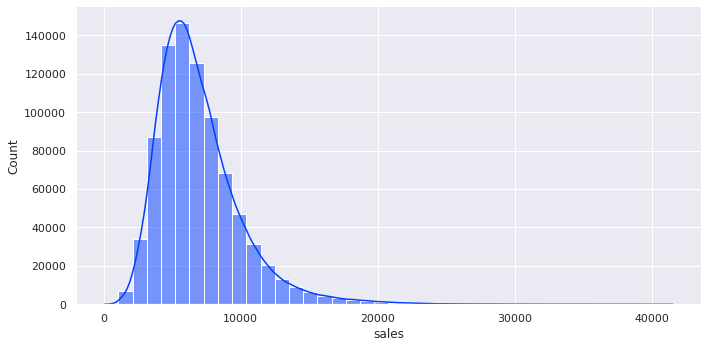

In [34]:
sns.displot(df_4['sales'],bins=40,aspect=2,kde=True)

### Numerical Variable

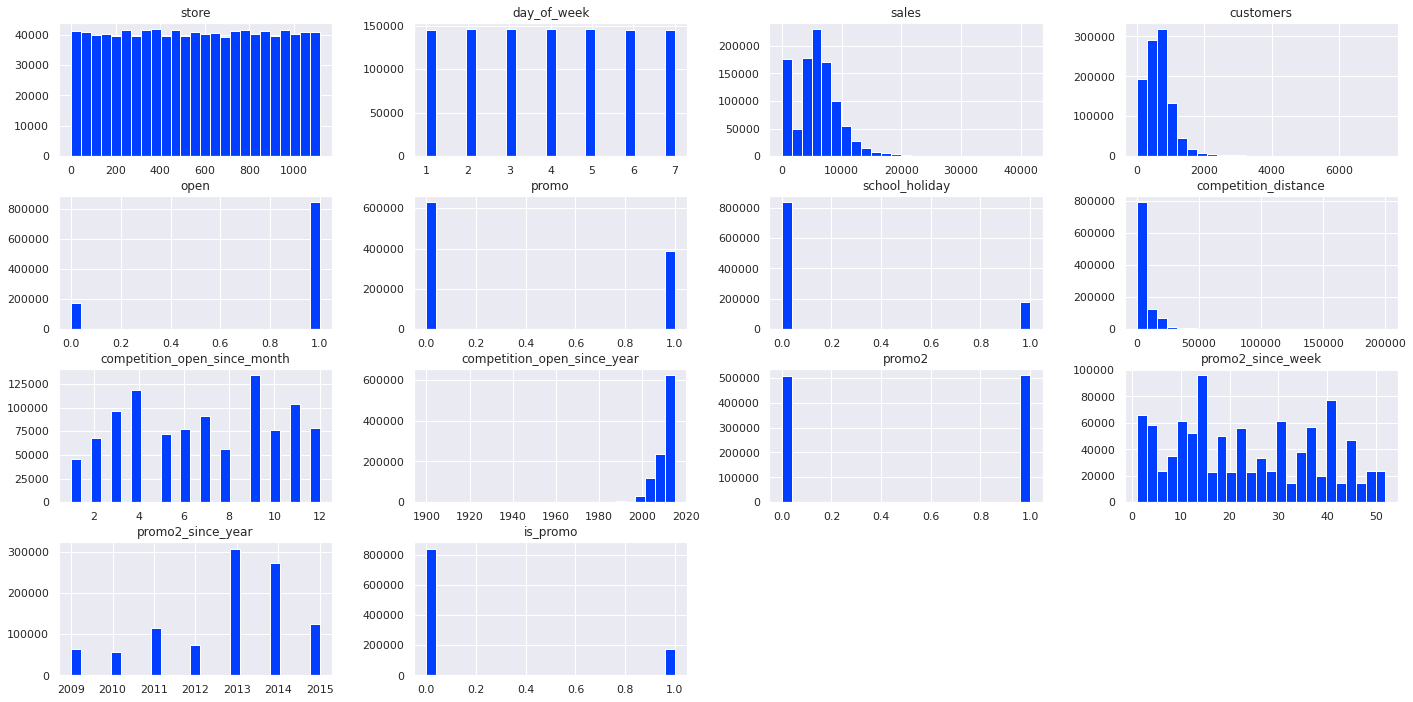

In [35]:
num_attributes.hist(bins=25,figsize=(24,12));

### Categorical Variable

/home/data_science/.pyenv/versions/3.8.8/envs/DsEmProd/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/data_science/.pyenv/versions/3.8.8/envs/DsEmProd/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/data_science/.pyenv/versions/3.8.8/envs/DsEmProd/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wi

<AxesSubplot:xlabel='sales', ylabel='Density'>

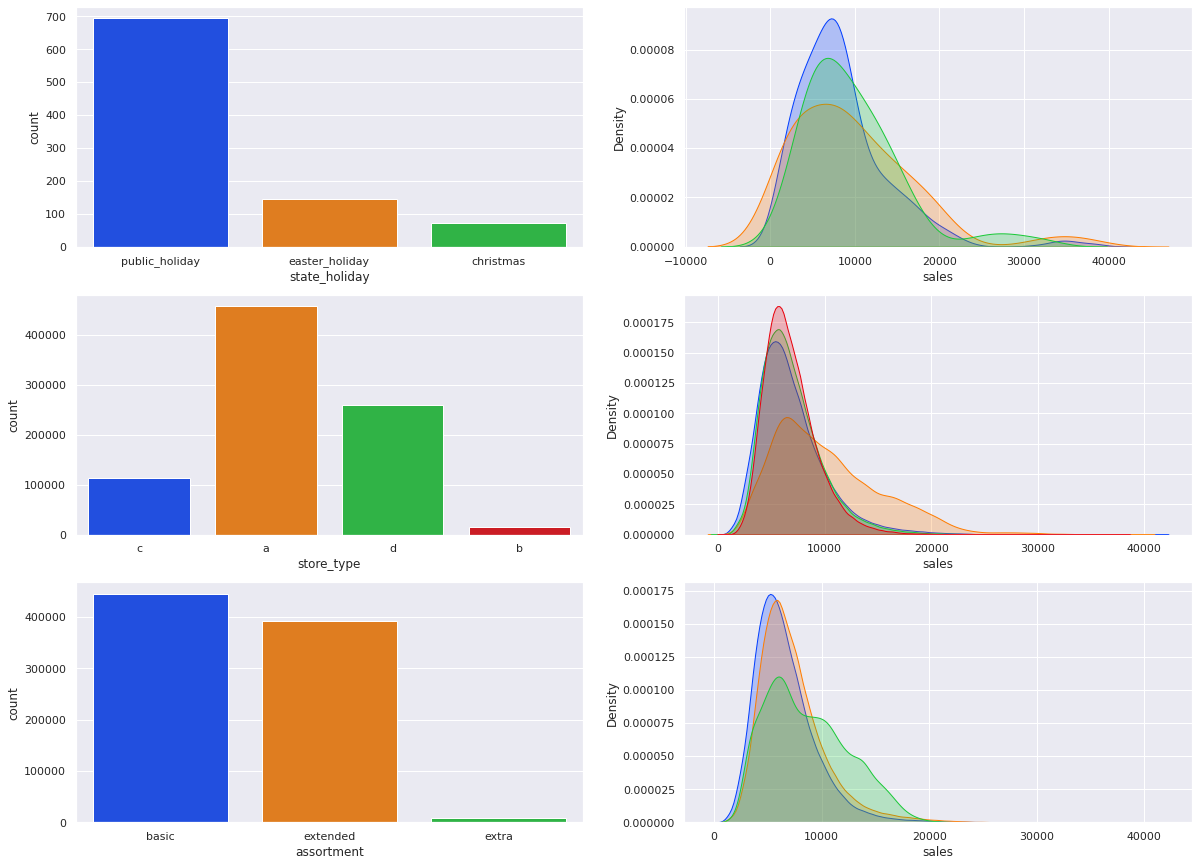

In [36]:
%matplotlib inline

# state_holiday 
holiday = df_4.loc[df_4['state_holiday']!='regular_day','state_holiday']
plt.figure(figsize=(20,15))

plt.subplot(3,2,1)
sns.countplot(holiday)

plt.subplot(3,2,2)
plt.ticklabel_format(style='plain', axis='y')
sns.kdeplot(df_4[df_4['state_holiday']=='public_holiday']['sales'],label='public_holiday',shade=True,legend='public_holiday')
sns.kdeplot(df_4[df_4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df_4[df_4['state_holiday']=='christmas']['sales'],label='christmas',shade=True)

# store_type
store_type = df_4['store_type']

plt.subplot(3,2,3)
sns.countplot(store_type)

plt.subplot(3,2,4)
plt.ticklabel_format(style='plain', axis='y')
sns.kdeplot(df_4[df_4['store_type']=='a']['sales'],shade=True)
sns.kdeplot(df_4[df_4['store_type']=='b']['sales'],shade=True)
sns.kdeplot(df_4[df_4['store_type']=='c']['sales'],shade=True)
sns.kdeplot(df_4[df_4['store_type']=='d']['sales'],shade=True)

# store_type
assortment = df_4['assortment']

plt.subplot(3,2,5)
sns.countplot(assortment)

plt.subplot(3,2,6)
plt.ticklabel_format(style='plain', axis='y')
sns.kdeplot(df_4[df_4['assortment']=='basic']['sales'],shade=True)
sns.kdeplot(df_4[df_4['assortment']=='extended']['sales'],shade=True)
sns.kdeplot(df_4[df_4['assortment']=='extra']['sales'],shade=True)



## --> Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais. 

Falsa, lojas com MAIOR SORTIMENTO vendem MENOS. 

<AxesSubplot:xlabel='year_week'>

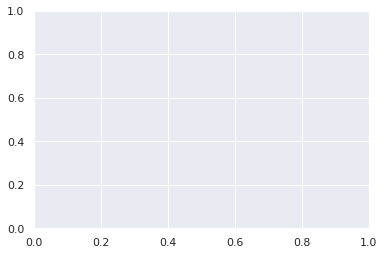

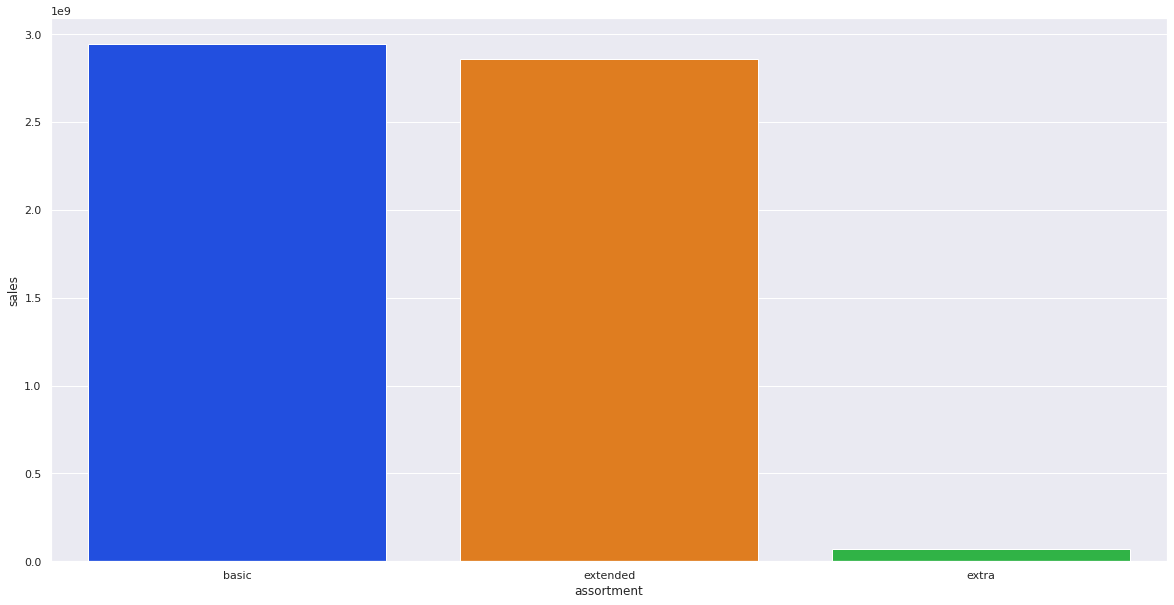

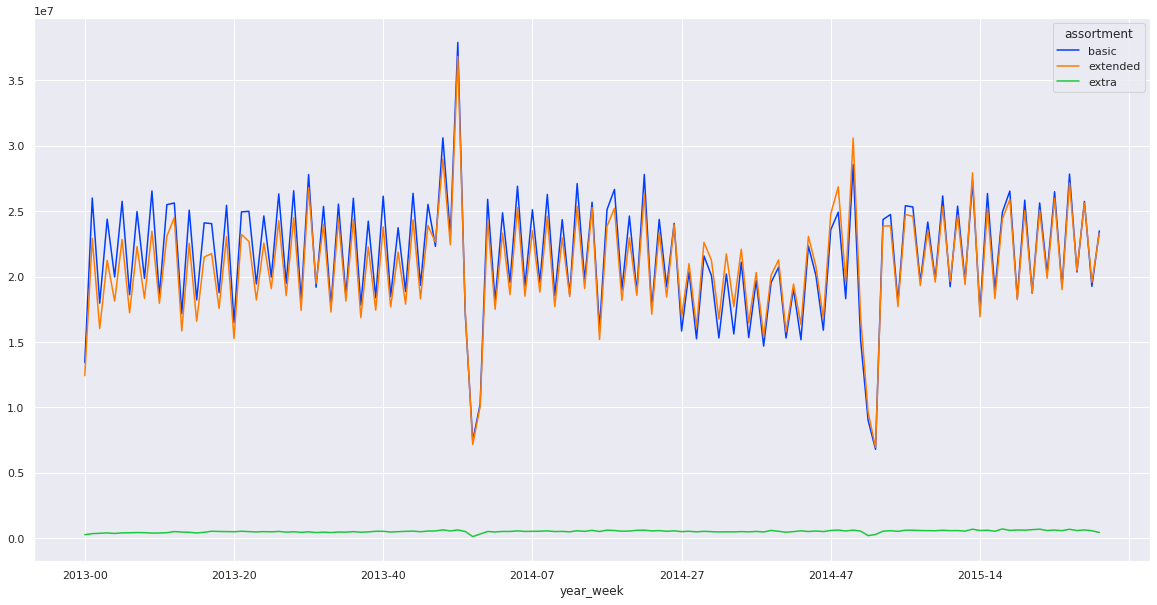

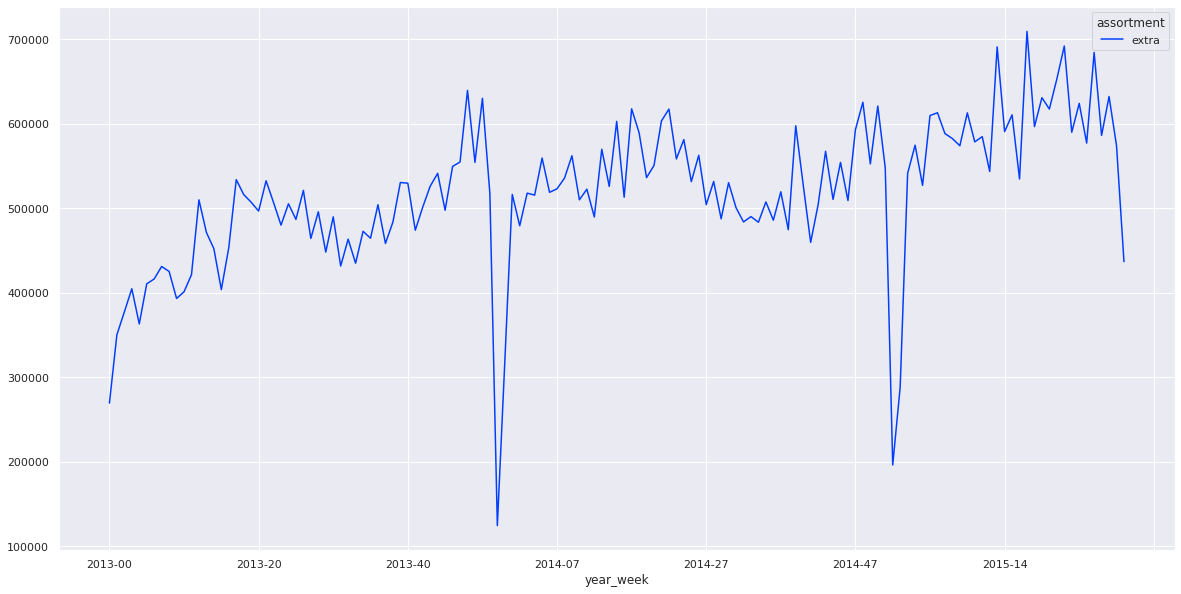

In [37]:
aux_1 = df_4[['assortment','sales']].groupby('assortment').sum().reset_index()
plt.ticklabel_format(style='plain',axis='y')

plt.figure(figsize=(20,10))
sns.barplot(x='assortment',y='sales',data=aux_1)

aux_2 = df_4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()

aux_2.pivot(index='year_week',columns='assortment', values='sales').plot(figsize=(20,10))

aux_3 = df_4.loc[df_4['assortment']=='extra',['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux_3.pivot(index='year_week',columns='assortment', values='sales').plot(figsize=(20,10))


### H2. Lojas com competidores mais próximos deveriam vender mais.

FALSA:Lojas com COMPETIDORES MAIS PRÓXIMOS VENDEM MAIS.

<AxesSubplot:>

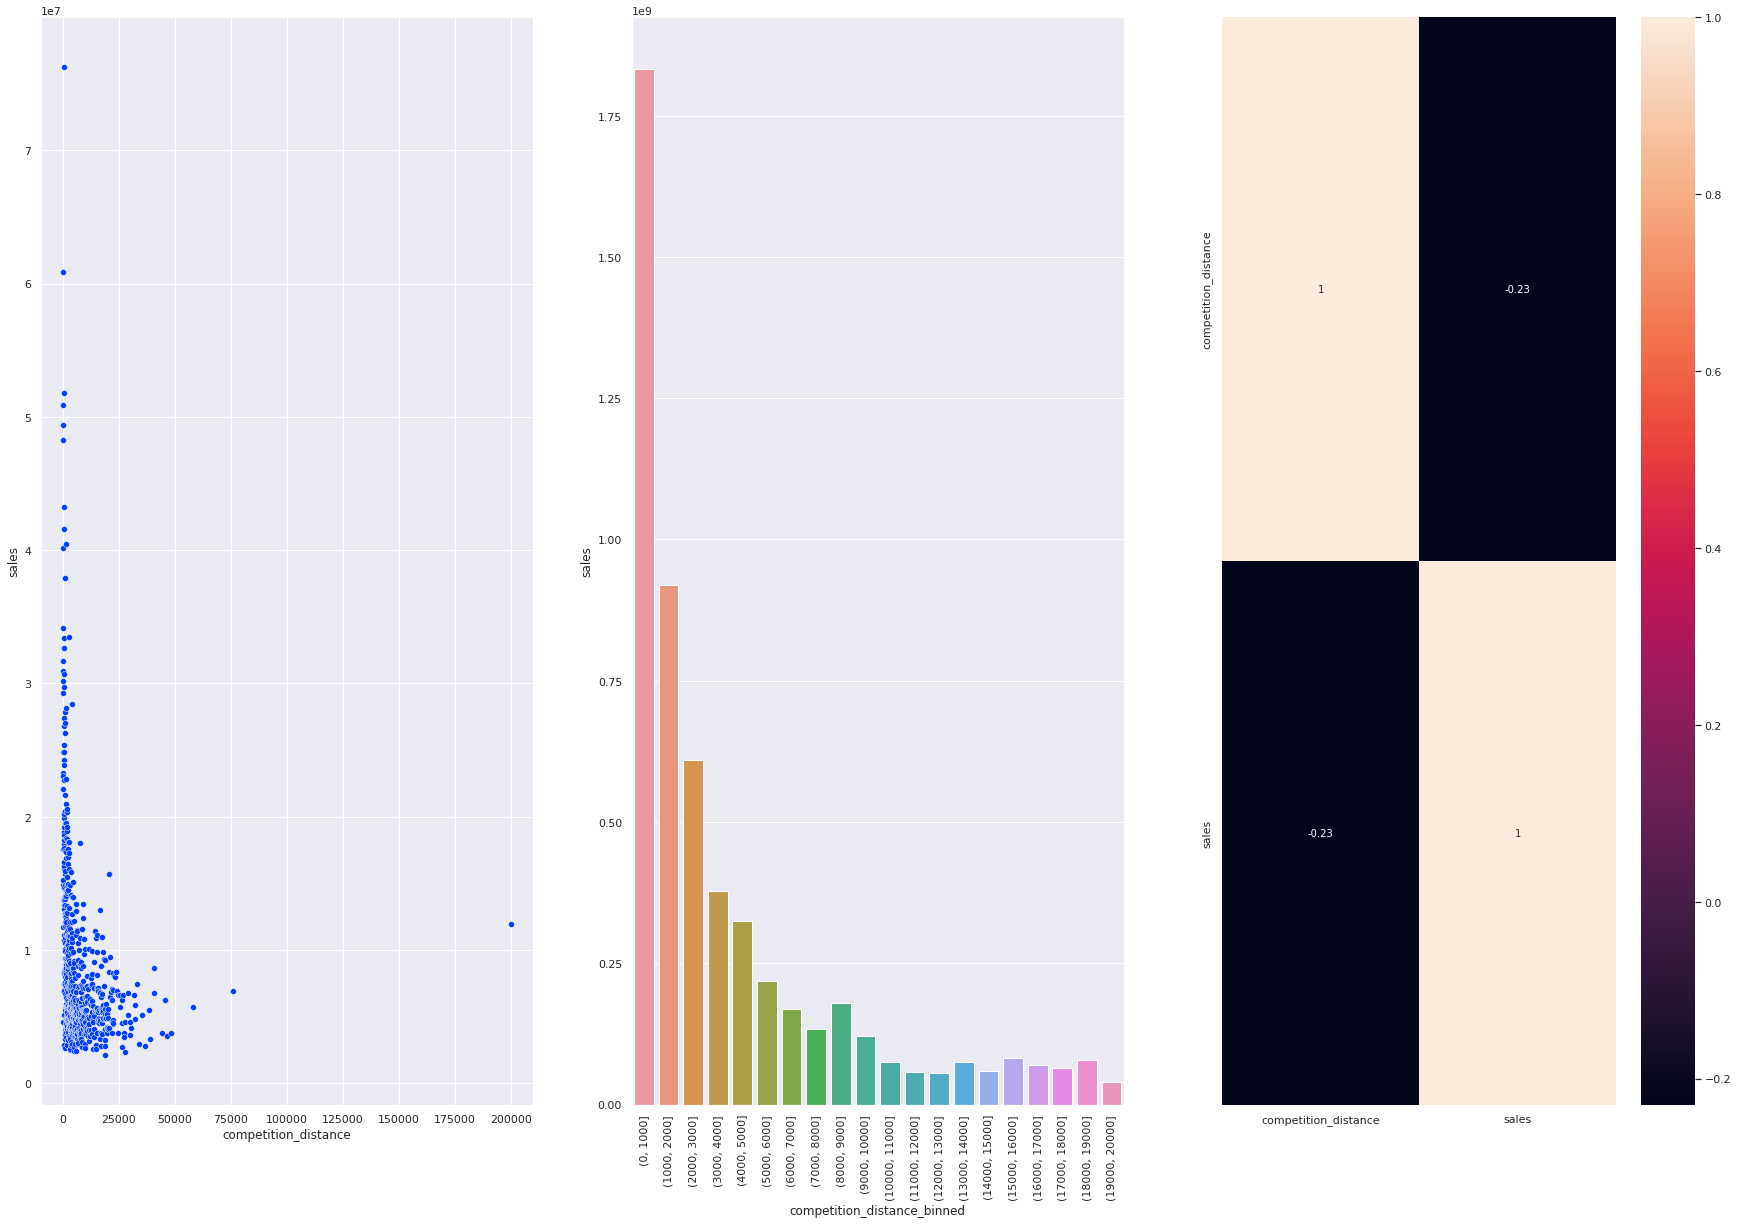

In [38]:
aux_1 = df_4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(30,20))

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux_1)

bins = list(np.arange(0,21000,1000))

aux_1['competition_distance_binned'] = pd.cut(aux_1['competition_distance'],bins=bins)
aux_2 = aux_1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
plt.xticks(rotation=90)
sns.barplot(x='competition_distance_binned',y='sales',data=aux_2)

plt.subplot(1,3,3)
sns.heatmap(aux_1.corr(method='pearson'), annot=True)

/home/data_science/.pyenv/versions/3.8.8/envs/DsEmProd/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_distance_binned', ylabel='sales'>

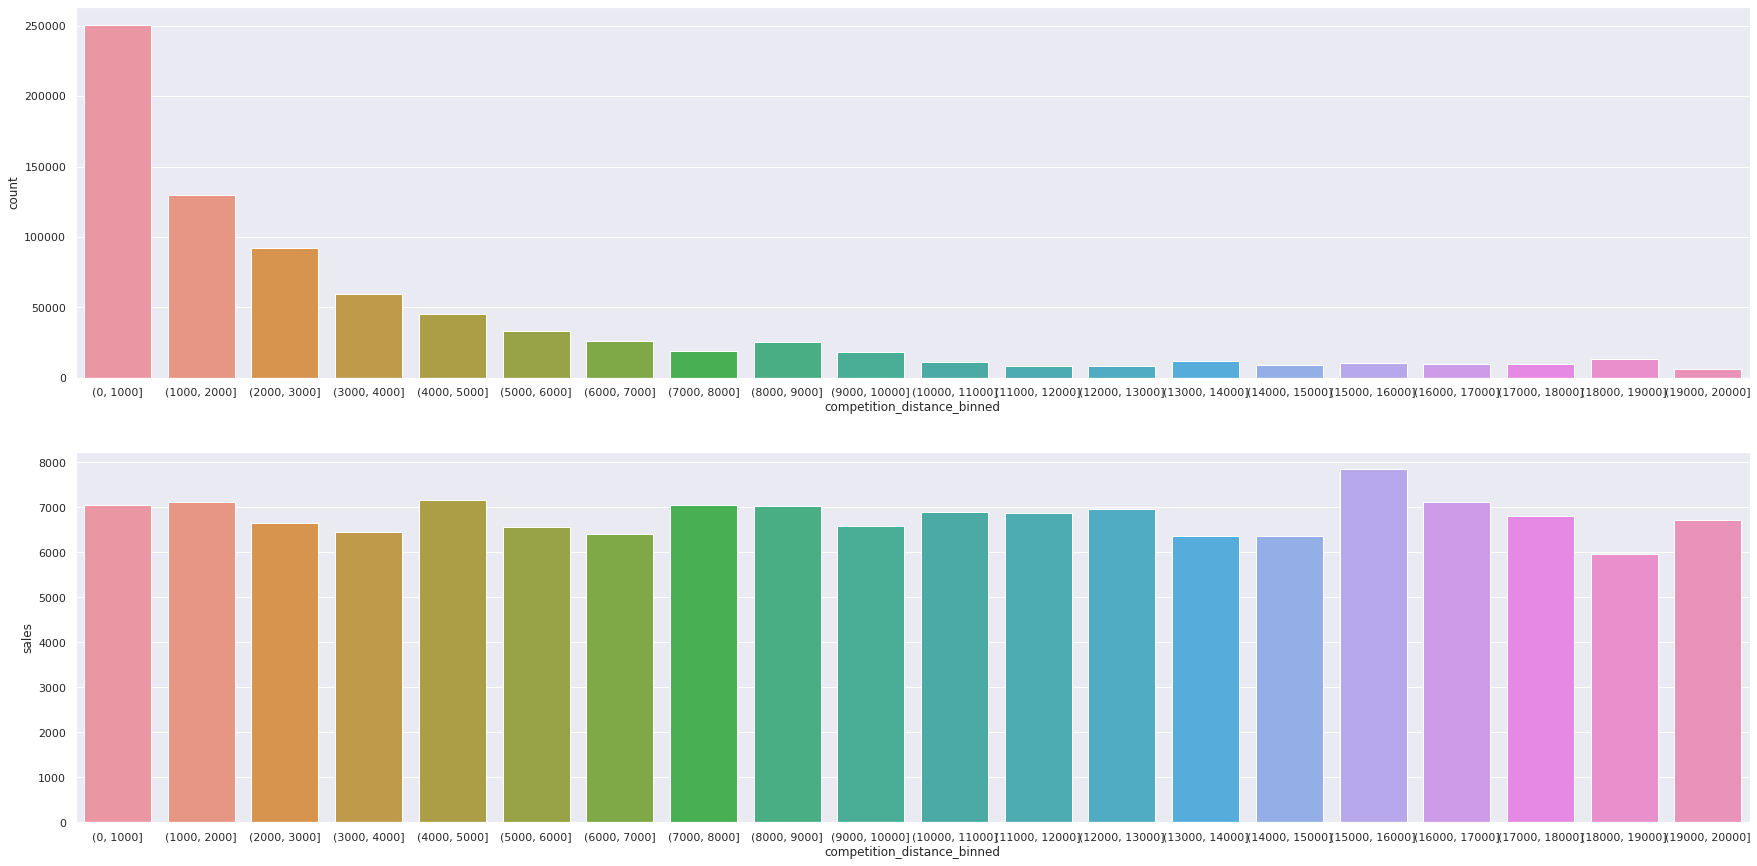

In [39]:
bins = list(np.arange(0,21000,1000))

df_4['competition_distance_binned'] = pd.cut(df_4['competition_distance'],bins=bins)

plt.figure(figsize=(30,15))

plt.subplot(2,1,1)
sns.countplot(df_4['competition_distance_binned'])

aux_1 = df_4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()
aux_1['competition_distance_binned'] = pd.cut(aux_1['competition_distance'],bins=bins)

aux_2 = aux_1[['competition_distance_binned','sales']].groupby('competition_distance_binned').mean().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='competition_distance_binned',y='sales',data=aux_2)


### H3. Lojas com competidores à mais tempo deveriam vender mais.  
FALSE, Lojas com COMPETIDORES À MAIS TEMPO. 

<AxesSubplot:xlabel='competition_time_month', ylabel='sales'>

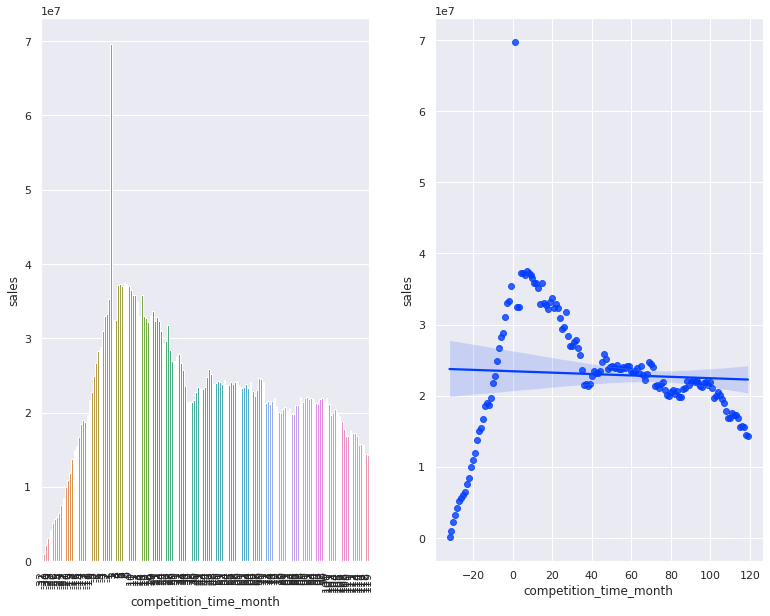

In [40]:
aux_1 = df_4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux_2 = aux_1[(aux_1['competition_time_month'] < 120)&(aux_1['competition_time_month']!=0)]

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month',y='sales',data=aux_2)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales', data=aux_2)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

FALSA, Lojas com promoções ativas por mais tempo deveriam vender mais, depois de um certo periodo de promoção.


<AxesSubplot:>

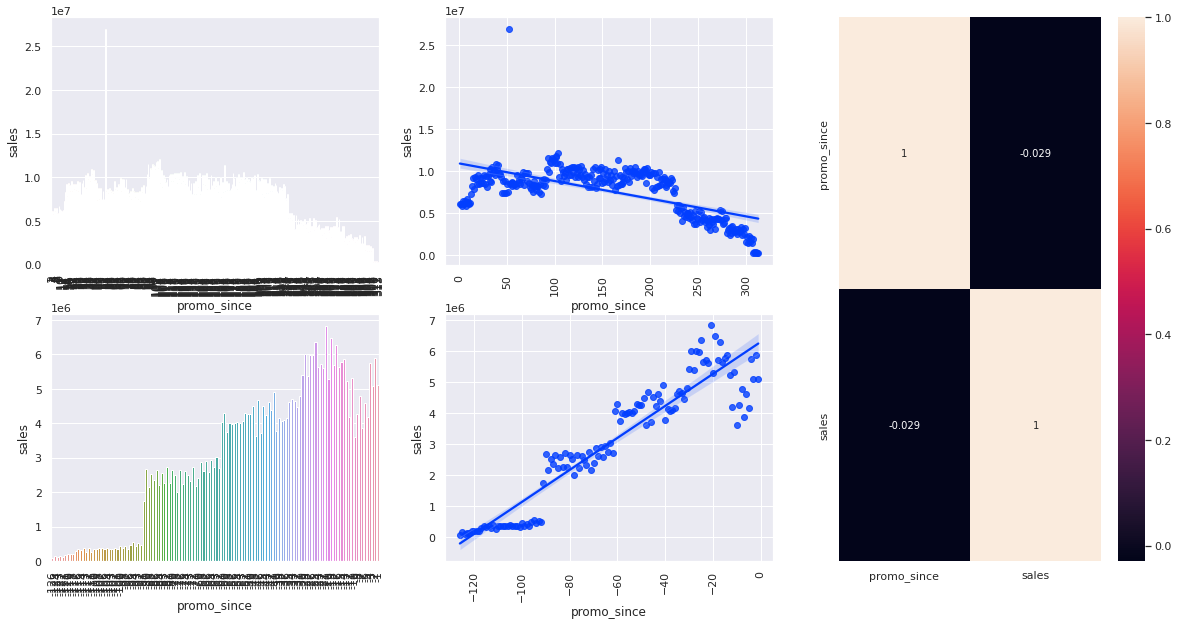

In [41]:
aux_1 = df_4[['promo_since','sales']].groupby('promo_since').sum().reset_index()

aux_2 = aux_1[aux_1['promo_since']>0] # promo extendido

fig = plt.figure(figsize=(20,10))
specs = gridspec.GridSpec(nrows=2, ncols=3,figure=fig)

plt.subplot(specs[0,0])
plt.xticks(rotation=90)
sns.barplot(x='promo_since',y='sales',data=aux_2)

plt.subplot(specs[0,1])
plt.xticks(rotation=90)
sns.regplot(x='promo_since',y='sales',data=aux_2)

aux_3 = aux_1[aux_1['promo_since']<0] # promo regular
plt.subplot(specs[1,0])
plt.xticks(rotation=90)
sns.barplot(x='promo_since',y='sales',data=aux_3)

plt.subplot(specs[1,1])
plt.xticks(rotation=90)
sns.regplot(x='promo_since',y='sales',data=aux_3)

plt.subplot(specs[:,2])
sns.heatmap(aux_1.corr(method='pearson'),annot=True)


### H5. Lojas com mais dias de promoção deveriam vender mais.


### H6. Lojas com mais promoções consectivas deveriam vender mais.
FALSA, Lojas com mias promoções consecutivas vendem menos. 

In [42]:
df_4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().sort_values(by='sales', ascending=False).reset_index()

,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


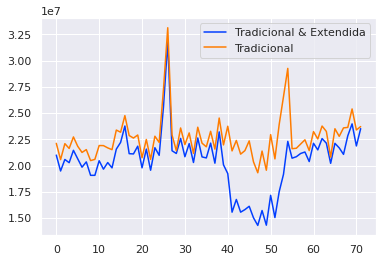

In [43]:
aux_1 = df_4[(df_4['promo']==1)&df_4['promo2']==1][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux_1.plot()

aux_2 = df_4[(df_4['promo']==1)&(df_4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux_2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Tradicional'])

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
FALSA, Lojas abertas durante o feriado do natal vendem menos.

<AxesSubplot:xlabel='year', ylabel='sales'>

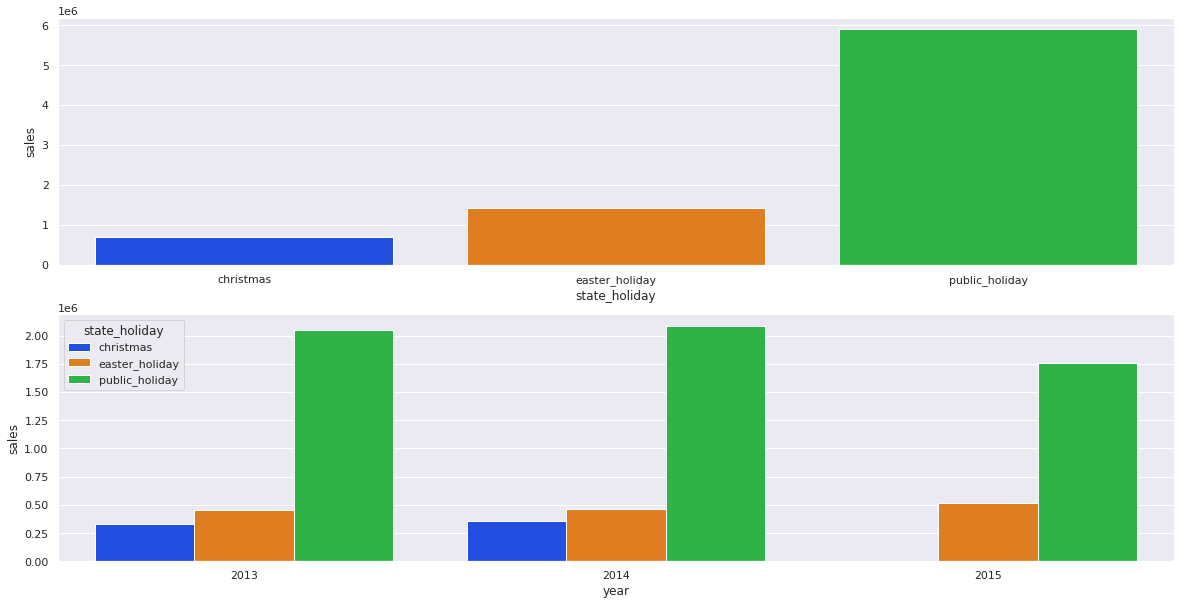

In [44]:
aux = df_4[df_4['state_holiday']!='regular_day']
aux_1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sns.barplot(x='state_holiday',y='sales',data=aux_1)

aux_2 = aux[['state_holiday','year','sales']].groupby(['year','state_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux_2)


### H8. Lojas deveriam vender mais ao,longo dos anos.
FALSA, Lojas vendem menos ao longo do ano.

<AxesSubplot:>

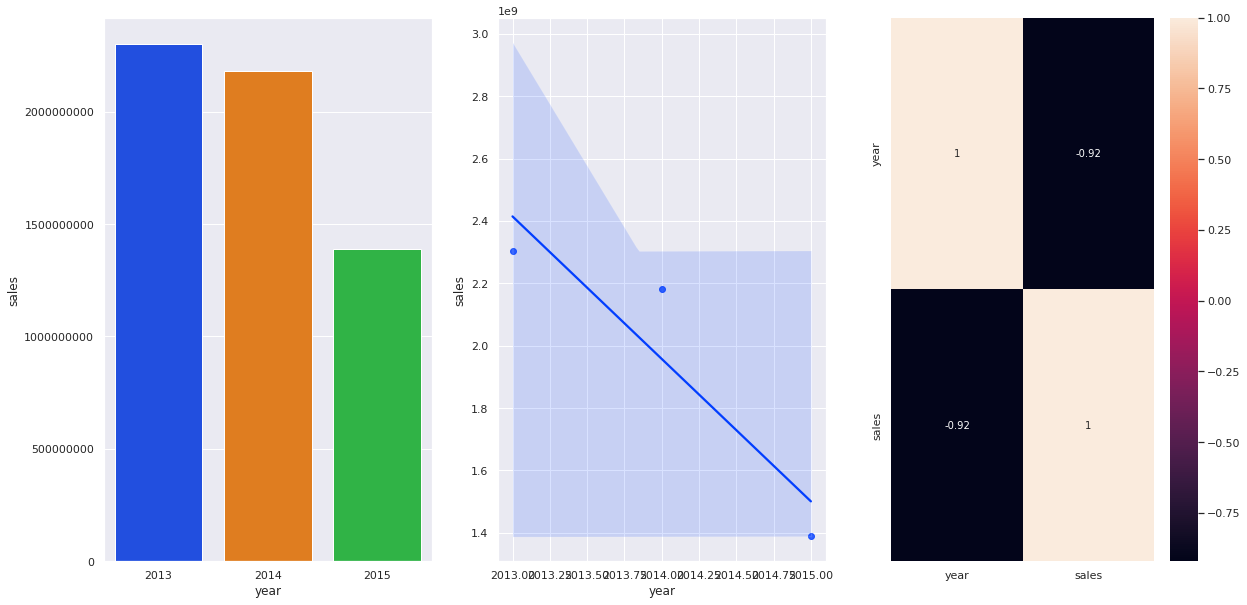

In [45]:
aux_1 = df_4[['year','sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.ticklabel_format(style='plain',axis='y')
sns.barplot(x='year',y='sales',data=aux_1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux_1)

plt.subplot(1,3,3)
sns.heatmap(aux_1.corr(method='pearson'),annot=True)

### H9. Lojas deveriam vender mais no segundo semestre do ano.
FALSA, Lojas vendem menos no segundo sementre do ano.

<AxesSubplot:>

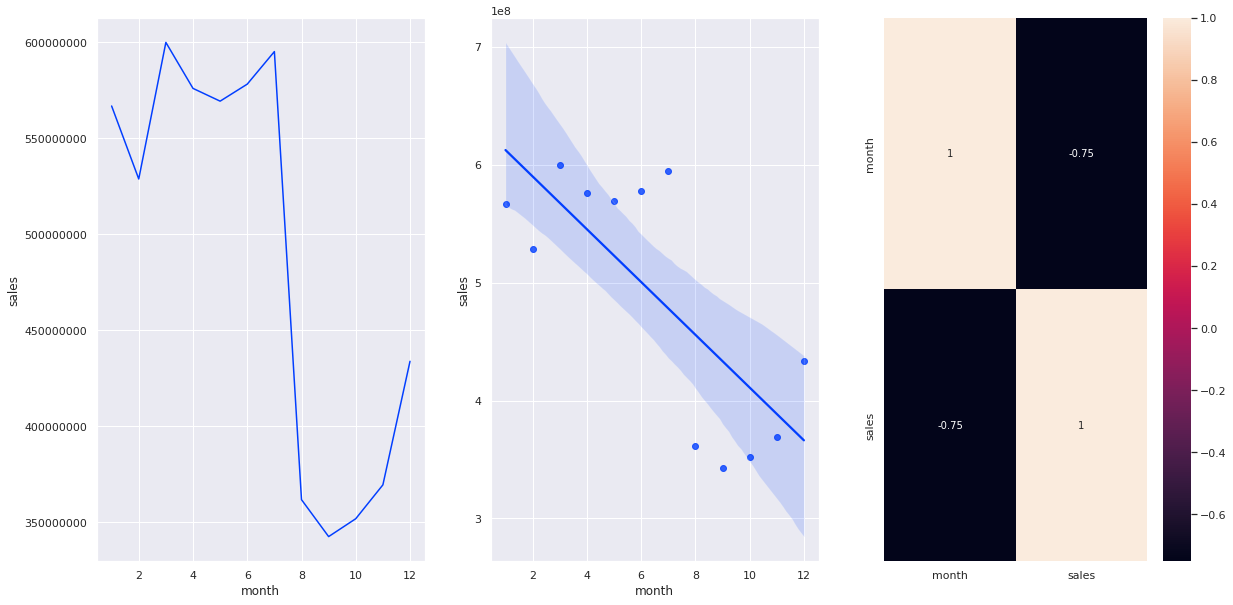

In [46]:
aux_1 = df_4[['month','sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.ticklabel_format(style='plain',axis='y')
sns.lineplot(x='month',y='sales',data=aux_1)

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux_1)

plt.subplot(1,3,3)
sns.heatmap(aux_1.corr(method='pearson'),annot=True)

### H10. Lojas deveriam vender mais depois do dia 1 de cada mes.
VERDADEIRA, LOjas vendem mais depois do dia 10 de cada mes.


/tmp/ipykernel_18912/1573483200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_1['day'] = df_4['date'].dt.day


<AxesSubplot:xlabel='before_after_day10', ylabel='sales'>

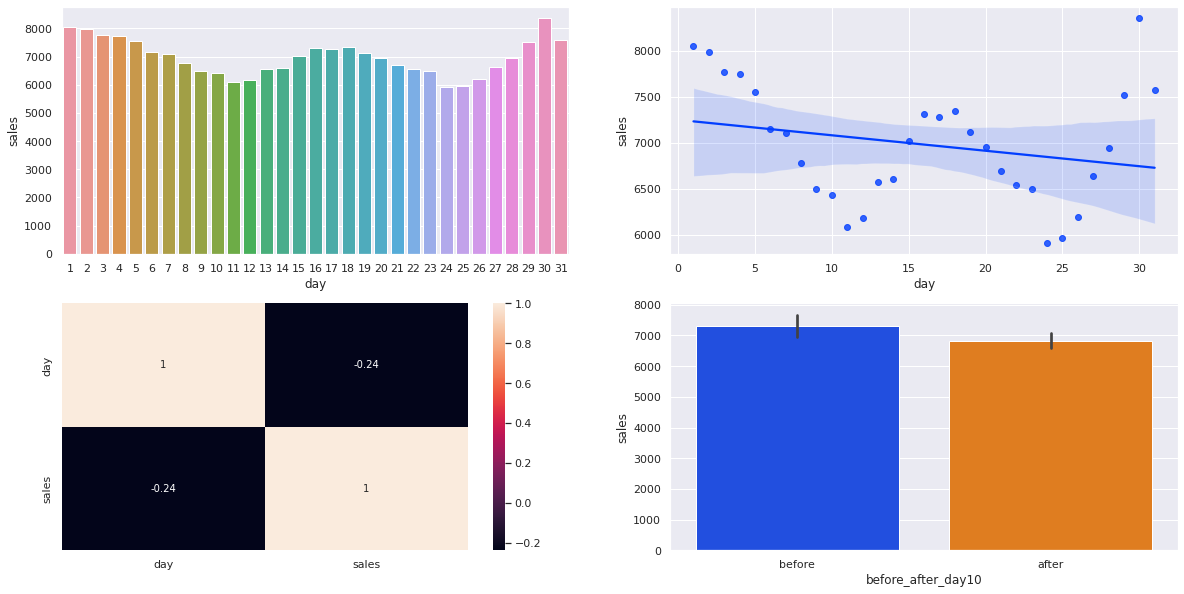

In [47]:
aux_1 = df_4[['sales','date']]
aux_1['day'] = df_4['date'].dt.day

aux_1 = aux_1[['sales','day']].groupby(['day']).mean().reset_index()
aux_1['before_after_day10'] = aux_1['day'].apply(lambda x:'before' if x <= 10 else 'after')

plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.ticklabel_format(style='plain',axis='y')
sns.barplot(x='day',y='sales',data=aux_1)

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux_1)

plt.subplot(2,2,3)
sns.heatmap(aux_1[['day','sales']].corr(method='pearson'),annot=True)

plt.subplot(2,2,4)
sns.barplot(x='before_after_day10',y='sales',data=aux_1)

### H11.Lojas deveriam vender menos aos finais de semana.
VERDADEIRA, Lojas vendem menos nos finais de semana.

<AxesSubplot:>

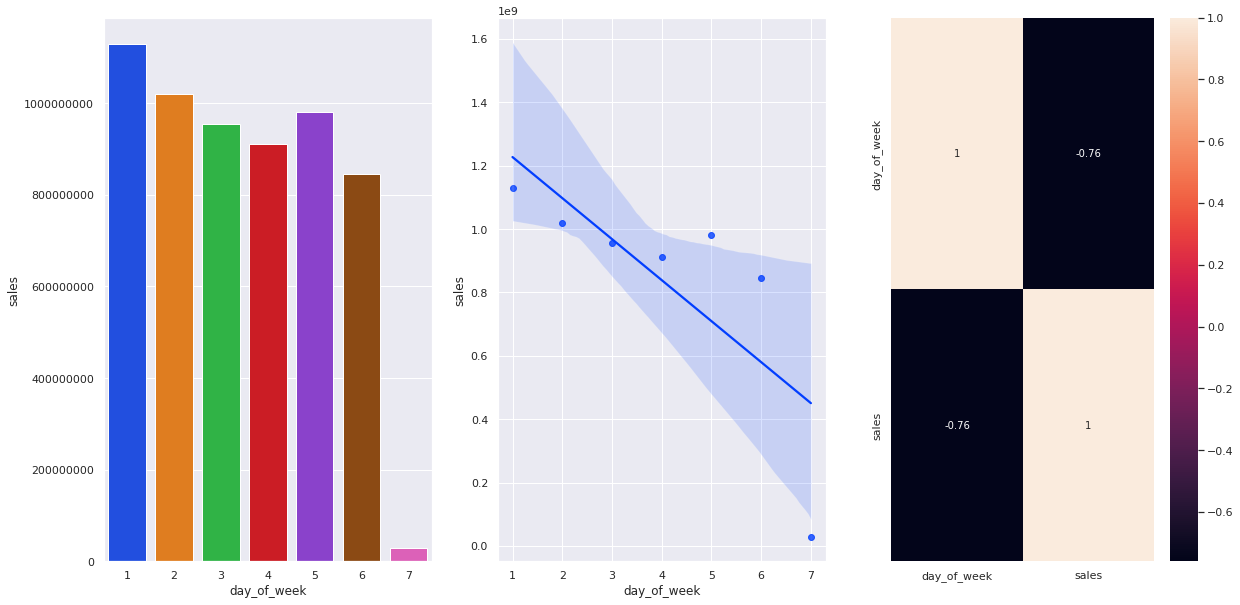

In [48]:
aux_1 = df_4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.ticklabel_format(style='plain',axis='y')
sns.barplot(x='day_of_week',y='sales',data=aux_1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux_1)

plt.subplot(1,3,3)
sns.heatmap(aux_1.corr(method='pearson'),annot=True)

### H12. Lojas deveriam vender menos durante os feriados escolares.


<AxesSubplot:xlabel='month', ylabel='sales'>

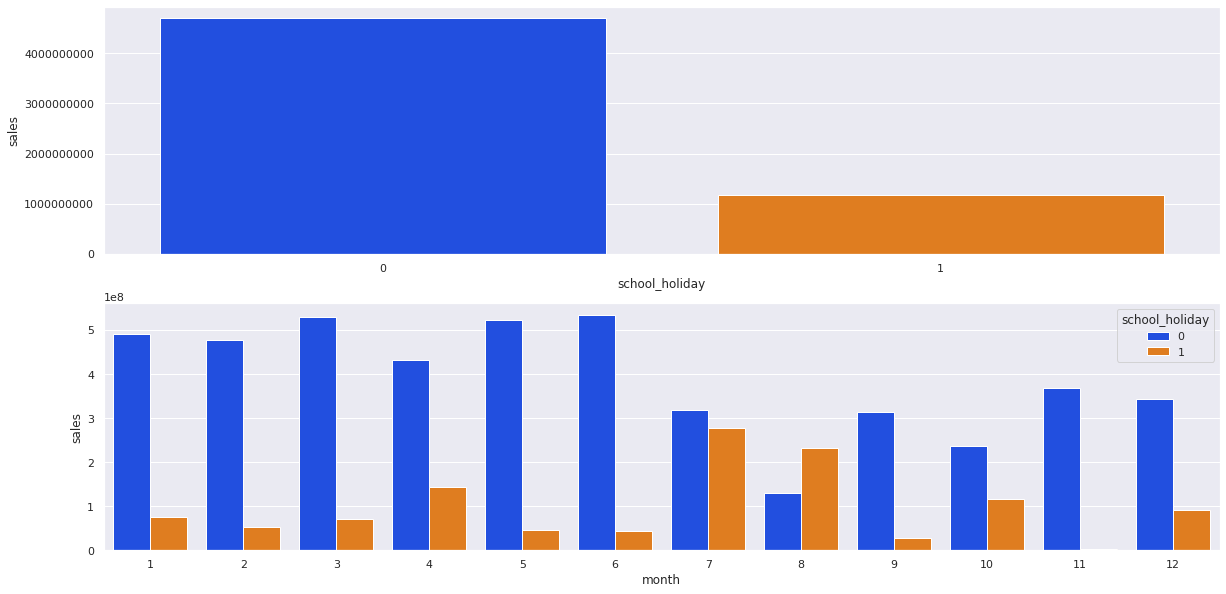

In [49]:
aux_1 = df_4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

aux_2 = df_4[['sales','month','school_holiday']].groupby(['month','school_holiday']).sum().reset_index()
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
plt.ticklabel_format(style='plain',axis='y')
sns.barplot(x='school_holiday',y='sales',data=aux_1)

plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux_2)

### Expectativas de relevancia das variaveis 

In [50]:
tab = [['hipoteses','conclusao','relevancia'],
        ['H1','Falsa','Baixa'],
        ['H2','Falsa','Media'],
        ['H3','Falsa','Media'],
        ['H4','Falsa','Baixa'],
        ['H5','-','-'],
        ['H6','Falsa','Baixa'],
        ['H7','Falsa','Media'],
        ['H8','Falsa','Alta'],
        ['H9','Falsa','Alta'],
        ['H10','Verdadeira','Alta'],
        ['H11','Verdadeira','Alta'],
        ['H12','Verdadeira','Baixa'],]
print(tabulate(tab,headers='firstrow'))

hipoteses    conclusao    relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## --> Análise Multivariada

### Numerical Attributes

<AxesSubplot:>

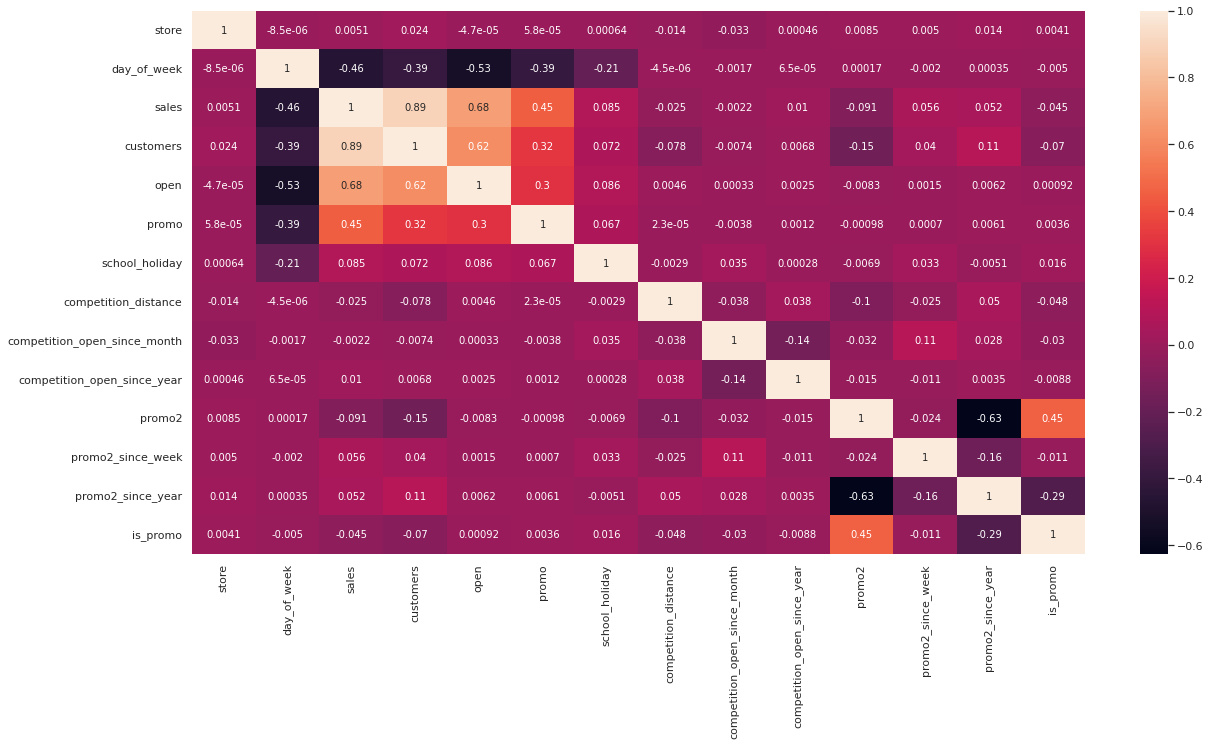

In [51]:
#metodo pearson para calcular as correlações das variaveis
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(correlation,annot=True)

### Categorical Attrinutes

In [52]:
cat_attributes = df_4.select_dtypes(include='object')
cat_attributes.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


<AxesSubplot:>

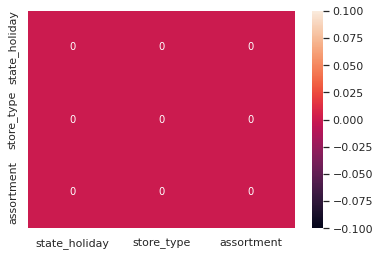

In [53]:
a1 = cramer_v(cat_attributes['state_holiday'],cat_attributes['state_holiday'])
a2 = cramer_v(cat_attributes['state_holiday'],cat_attributes['store_type'])
a3 = cramer_v(cat_attributes['state_holiday'],cat_attributes['assortment'])

a4 = cramer_v(cat_attributes['store_type'],cat_attributes['state_holiday'])
a5 = cramer_v(cat_attributes['store_type'],cat_attributes['store_type'])
a6 = cramer_v(cat_attributes['store_type'],cat_attributes['assortment'])

a7 = cramer_v(cat_attributes['assortment'],cat_attributes['state_holiday'])
a8 = cramer_v(cat_attributes['assortment'],cat_attributes['store_type'])
a9 = cramer_v(cat_attributes['assortment'],cat_attributes['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9],})
d.set_index(d.columns, inplace=True)

sns.heatmap(data=d, annot=True)

# Preparação dos Dados

In [54]:
df_5 = df_4.copy()

## Normalização

## Rescaling

In [55]:
aux_1 = df_5.select_dtypes(include=['int64','float64'])

/home/data_science/.pyenv/versions/3.8.8/envs/DsEmProd/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

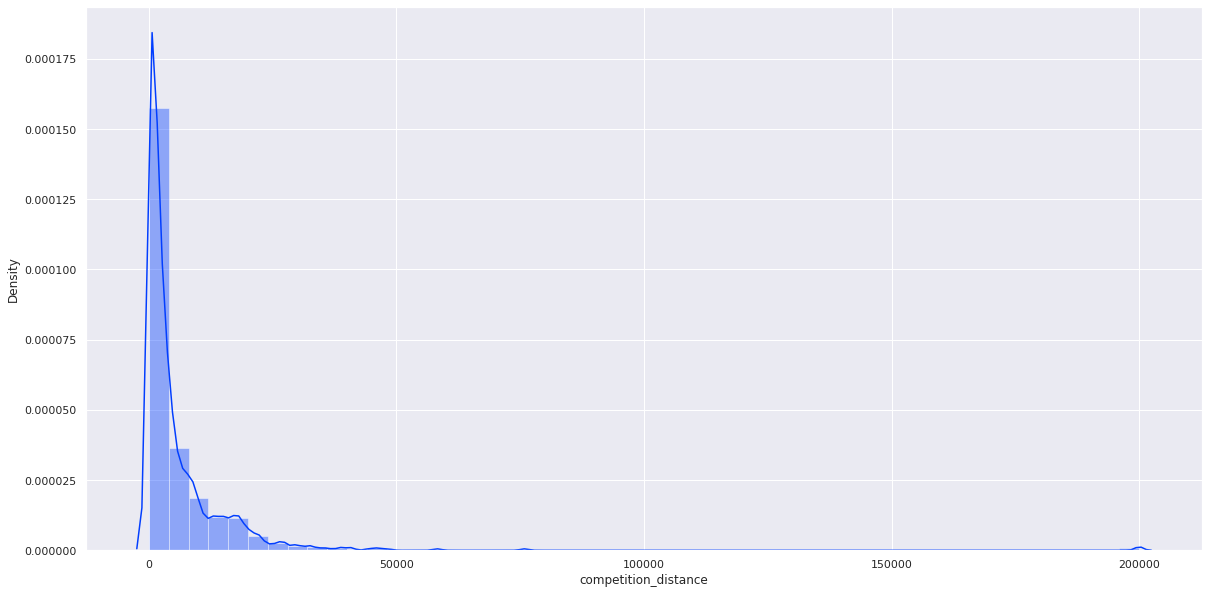

In [56]:
plt.figure(figsize=(20,10))
#sns.boxplot(data=df_5['promo_since'],orient='horizontal')
sns.distplot(df_5['competition_distance'])

In [57]:
#MIn_Max_Scaler
mms = MinMaxScaler()

# promo_time_week/promo_since
df_5['promo_since'] = mms.fit_transform(df_5[['promo_since']].values) 

# year
df_5['year'] = mms.fit_transform(df_5[['year']].values)
#----------------------------------
#Robust_Scaler
rs = RobustScaler()

# competition_distance
df_5['competition_distance'] = rs.fit_transform(df_5[['competition_distance']].values) 

# competition_time_month
df_5['competition_time_month'] = rs.fit_transform(df_5[['competition_time_month']].values) 


## Tranformação

### Encoding

In [58]:
#state_holiday - One Hot Enconding
df_5 = pd.get_dummies(df_5,prefix=['state_holiday'],columns=['state_holiday'])

#store_type - Label Enconding
le = LabelEncoder()
df_5['store_type'] = le.fit_transform(df_5['store_type'])

#assortment - Ordinal Enconding 
assortment_dict = {'basic':1,'extra':2,'extended':3}
df_5['assortment'] = df_5['assortment'].map(assortment_dict)

### Response Variable Transformation

In [59]:
df_5['sales'] = np.log1p(df_5['sales'])

### Nature Transformation

In [60]:
# month
df_5['month_sin'] = df_5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df_5['month_cos'] = df_5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# week_of_year
df_5['week_of_year_sin'] = df_5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df_5['week_of_year_cos'] = df_5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day_of_week
df_5['day_of_week_sin'] = df_5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df_5['day_of_week_cos'] = df_5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))


In [61]:
df_5.sample(15)

,index,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,...,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
67823,80475,196,3,2015-05-20,8.733594,1,0,2,1,0.245161,...,0,0,0,1,5.000000e-01,-8.660254e-01,0.568065,-8.229839e-01,0.433884,-0.900969
816960,984144,385,3,2013-01-30,8.637107,0,0,3,1,0.362903,...,0,0,0,1,5.000000e-01,8.660254e-01,0.568065,8.229839e-01,0.433884,-0.900969
560434,676385,366,6,2013-11-02,8.187577,0,0,3,3,0.667742,...,0,0,0,1,-5.000000e-01,8.660254e-01,-0.822984,5.680647e-01,-0.781831,0.623490
495953,596174,435,1,2014-01-13,8.195885,0,0,0,1,-0.229032,...,0,0,0,1,5.000000e-01,8.660254e-01,0.354605,9.350162e-01,0.781831,0.623490
299065,360212,489,4,2014-08-21,8.997518,1,1,0,1,2.037097,...,0,0,0,1,-8.660254e-01,-5.000000e-01,-0.822984,-5.680647e-01,-0.433884,-0.900969
469177,564930,411,1,2014-02-10,8.769041,0,0,3,3,0.988710,...,0,0,0,1,8.660254e-01,5.000000e-01,0.748511,6.631227e-01,0.781831,0.623490
752066,905808,99,3,2013-04-10,8.375630,1,0,2,3,-0.048387,...,0,0,0,1,8.660254e-01,-5.000000e-01,0.970942,-2.393157e-01,0.433884,-0.900969
140159,169158,794,1,2015-03-02,8.226841,1,0,2,3,0.445161,...,0,0,0,1,1.000000e+00,6.123234e-17,0.935016,3.546049e-01,0.781831,0.623490
590460,712558,859,2,2013-10-01,8.783396,0,0,2,1,3.135484,...,0,0,0,1,-8.660254e-01,5.000000e-01,-0.992709,1.205367e-01,0.974928,-0.222521
763869,922025,706,3,2013-03-27,8.819518,1,1,3,1,0.887097,...,0,0,0,1,1.000000e+00,6.123234e-17,1.000000,6.123234e-17,0.433884,-0.900969


# Features Selection 

In [94]:
df_6 = df_5.copy()

## Split dataframe into training and test dataset

In [95]:
cols_drop = ['week_of_year','month','day_of_week','competition_since','year_week','competition_distance_binned']
df_6 = df_6.drop(columns=cols_drop, axis=1)

In [96]:
df_6[['store','date']].groupby('store').max().reset_index()['date'][0] - dt.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [97]:
# Trainig dataset
x_train = df_6[df_6['date'] < '2015-06-19']
y_train = x_train['sales']

# Test dataset
x_test = df_6[df_6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training Min Date: {}'.format(x_train['date'].min()))
print('Training Max Date: {}'.format(x_train['date'].max()))

print('\nTest Min Date: {}'.format(x_test['date'].min()))
print('Test Max Date: {}'.format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as Feature Selector

In [66]:
# #training and test dataset for Boruta
# x_train_n = x_train.drop(columns = ['date','sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# #define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=1)

# # define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

## Best Features from Boruta

In [67]:
##uma lista das features ranqueadas --> devolve um vetor de numeros
cols_selected = boruta.support_.tolist()

# best features 
x_train_fs = x_train.drop(['date','sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

# not selected boruta
## setdiff1d:devolve as diferenças entre as arrays
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

NameError: name 'boruta' is not defined

In [68]:
['store',  
 'sales', 
 'promo', 
 'store_type', 
 'assortment', 
 'competition_distance',
 'competition_open_since_month', 
 'competition_open_since_year', 
 'promo2',
 'promo2_since_week', 
 'promo2_since_year',  
 'competition_time_month',
 'promo_since', 
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin', 
 'month_cos',
 'week_of_year_sin', 
 'week_of_year_cos'] 

['store',
 'sales',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_since',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [69]:
['is_promo',
'month_sin', 
'school_holiday',
'state_holiday_christmas',
'state_holiday_easter_holiday',
'state_holiday_public_holiday',
'state_holiday_regular_day',
'week_of_year_sin',
'year']

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## Manual Features Selection

In [98]:
cols_selected_boruta = [
 'store',  
 'sales', 
 'promo', 
 'store_type', 
 'assortment', 
 'competition_distance',
 'competition_open_since_month', 
 'competition_open_since_year', 
 'promo2',
 'promo2_since_week', 
 'promo2_since_year',  
 'competition_time_month',
 'promo_since', 
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin', 
 'month_cos',
 'week_of_year_sin', 
 'week_of_year_cos'] 

feat_add = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_add)

# Machine Learning Modelling

In [99]:
x_training = x_train[cols_selected_boruta_full]

In [100]:
x_train = x_train[cols_selected_boruta]
x_test = x_test[cols_selected_boruta]

## Average Model

In [73]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y_true=y,y_pred=yhat)
    mape = mean_absolute_percentage_error(y_true=y,y_pred=yhat)
    rmse = mean_squared_error(y_true=y,y_pred=yhat)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    return pd.DataFrame({'Model Name':model_name, 'MAE':mae, 'MAPE':mape, 'RMSE':rmse}, index=[0])

In [74]:
aux_1 = x_test.copy()
aux_1['sales'] = y_test.copy()

#prediction
aux_2 = aux_1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux_1 = pd.merge(left=aux_1,right=aux_2,how='left',on='store')
yhat_baseline = aux_1['predictions']

#perfomance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800,0.206,3367722.459


## Linear Regression

In [75]:
# model
lr = LinearRegression().fit(x_train,y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', y=np.expm1(y_test), yhat=np.expm1(yhat_lr))
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,0.000,0.000,0.000


### Linear Regressioon Model - Cross Validation

In [76]:
lr_result_cv = cross_validation(x_training=x_training, kfold=5, model_name='Linear Regression', model=lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2047.08 +/- 300.65,0.3 +/- 0.02,8482429.82 +/- 3135537.91


## Linear Regression Regularized Model

In [77]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', y=np.expm1(y_test), yhat=np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,135.594,0.018,52562.992


### Linear Regressioon Regularized Model (LASSO) - Cross Validation

In [78]:
lrr_result_cv = cross_validation(x_training, kfold=3, model_name= 'LASSO',model= lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LASSO,1954.8 +/- 173.64,0.28 +/- 0.01,7868634.64 +/- 1832610.19


## Random Forest Regressor

In [79]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=1, random_state=42).fit(x_train,y_train)

#prediction
yhat_rf = rf.predict(x_test)

#perfomance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.100,0.000,302.831


### Ramdom Forest Regressor - Cross Validation

In [80]:
rf_result_cv = cross_validation(x_training, kfold=3, model_name= 'Random Forest Regressor',model= rf, verbose=True)
rf_result_cv

kFold Number: 3
kFold Number: 2
kFold Number: 1
kFold Number: 0


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,749.6 +/- 162.8,0.11 +/- 0.01,1232670.81 +/- 590485.88


In [81]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,749.6 +/- 162.8,0.11 +/- 0.01,1232670.81 +/- 590485.88


## XGBoost Regressor

In [91]:
#model 
model_xgb = xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimator = 100,
    eta = 0.01,
    max_depth = 10,
    subsample = 0.7,
    colsample_bytee = 0.9
).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#perfomance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[18:48:47] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytee", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6673.911,0.951,53300002.141


### XGBoost Regressor - Cross Validation

In [110]:
#model 
model_xgb = MultiOutputRegressor(xgb.XGBRegressor(
    objective = 'reg:squarederror',
    n_estimator = 100,
    eta = 0.01,
    max_depth = 10,
    subsample = 0.7,
    colsample_bytee = 0.9
))
xgb_result_cv = cross_validation(x_training=x_training, kfold=3, model_name= 'XGboost Regressor',model= model_xgb, verbose=True)
xgb_result_cv

kFold Number: 3
[19:04:41] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytee", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:05:36] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytee", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


kFold Number: 2
[19:06:33] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytee", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  t

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGboost Regressor,6907.11 +/- 366.13,0.95 +/- 0.0,56266890.43 +/- 6176560.1


## Compare Model's Perfomance

### Single Perfonmance

In [ ]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result], ignore_index=True)
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
1,Linear Regression,0.000,0.000,0.000
3,Random Forest Regressor,0.100,0.000,302.831
2,Linear Regression - Lasso,135.594,0.018,52562.992
0,Average Model,1354.800,0.206,3367722.459
4,XGBoost Regressor,6673.911,0.951,53300002.141


### Real Perfonmance - Cross Validation

In [113]:
modeling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modeling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGboost Regressor,6907.11 +/- 366.13,0.95 +/- 0.0,56266890.43 +/- 6176560.1
0,LASSO,1954.8 +/- 173.64,0.28 +/- 0.01,7868634.64 +/- 1832610.19
0,Linear Regression,2047.08 +/- 300.65,0.3 +/- 0.02,8482429.82 +/- 3135537.91


## Hyperparameter Fine Tuning

### Random Search

In [140]:
param = {
    'n_estimators':[15,17,25,30,35],
    'eta':[0.01,0.03],
    'max_depth': [3,5,9],
    'subsample' : [0.1,0.5,0.7],
    'colsample_bytree' : [0.3,0.7,0.9],
    'min_child_weight':[3,8,15]
    }

In [125]:
import random
import warnings
warnings.filterwarnings('ignore')

In [141]:
MAX_EVAL = 2

final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # Choose values for parameters randomly
    hp = {k:random.sample(v,1)[0] for k,v in param.items()}
    print (hp)
    #model 
    
    model_xgb = MultiOutputRegressor(xgb.XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = hp['n_estimators'],
        eta = hp['eta'],
        max_depth = hp['max_depth'],
        subsample = hp['subsample'],
        colsample_bytree = hp['colsample_bytree'],
        min_child_weight = hp['min_child_weight']
    ))

    #perfomance
    result =cross_validation(x_training=x_training, kfold=2, model_name='XGBoost Regressor',model=model_xgb,verbose=True)
    final_result = pd.concat([final_result,result])

final_result

{'n_estimators': 30, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
kFold Number: 2
kFold Number: 1
kFold Number: 0
{'n_estimators': 15, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
kFold Number: 2
kFold Number: 1
kFold Number: 0


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7388.19 +/- 134.97,1.0 +/- 0.0,63501653.82 +/- 3971072.85
0,XGBoost Regressor,7367.87 +/- 135.15,0.99 +/- 0.0,63197570.52 +/- 3970620.98


In [143]:
final_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7367.87 +/- 135.15,0.99 +/- 0.0,63197570.52 +/- 3970620.98
0,XGBoost Regressor,7388.19 +/- 134.97,1.0 +/- 0.0,63501653.82 +/- 3971072.85


### Final Model

In [145]:
param_tuned = {
    'n_estimators':15,
    'eta':0.03,
    'max_depth':5,
    'subsample':0.7 ,
    'colsample_bytree':0.7 ,
    'min_child_weight':3
    }

In [148]:
model_xgb_tuned = xgb.XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = param_tuned['n_estimators'],
        eta = param_tuned['eta'],
        max_depth = param_tuned['max_depth'],
        subsample = param_tuned['subsample'],
        colsample_bytree = param_tuned['colsample_bytree'],
        min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#perfomance
xgb_result_tuned = ml_error(model_name='XGBoost Regressor', y = np.expm1(y_test), yhat=np.expm1(yhat_xgb_tuned))

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6961.712,0.995,57704716.933
